<a href="https://colab.research.google.com/github/jyoshika1976/jyoshi/blob/main/blood_group_classification_(1)_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname,_,filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname,filename)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img,img_to_array,save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
!unzip "/content/archive.zip"



Streaming output truncated to the last 5000 lines.
  inflating: dataset_blood_group/A-/cluster_1_3319.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3326.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3329.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3350.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3353.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3356.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3372.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3381.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3394.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3404.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3409.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3414.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3416.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3421.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3423.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3424.BMP  
  inflating: dataset_blood_group/A-/c

In [ ]:
dataset_path="/content/dataset_blood_group"

In [ ]:
BATCH_SIZE=32

In [ ]:
#step-1 : LOAD DATASET
dataset= image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64,64),
    batch_size=BATCH_SIZE,
    shuffle=True,
)


Found 6000 files belonging to 8 classes.


In [ ]:
# Step 2  CHECK CLASS DISTRIBUTION

class_names= dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
  class_counts[int(labels.numpy())]+=1
print("Class Distribution: ")
for i, count in class_counts.items():
  print(f"{class_names[i]}: {count}")

Class Distribution: 
O+: 852
B-: 741
B+: 652
AB-: 761
A+: 565
O-: 712
A-: 1009
AB+: 708


In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
  classes=[class_names[i] for i in class_counts.keys()]
  counts=[class_counts[i] for i in class_counts.keys()]
  plt.figure(figsize=(10,6))
  plt.bar(classes,counts)
  plt.xlabel("Class")
  plt.ylabel("Count")
  plt.title("Class Distribution")
  plt.show()

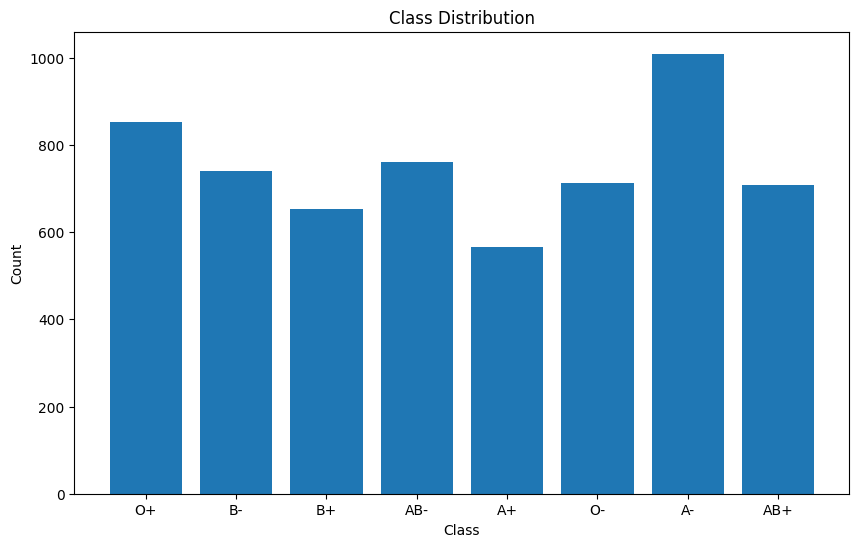

In [ ]:
 plot_class_distribution(class_names,class_counts)

In [ ]:
max_count= max(class_counts.values())

In [ ]:
# FUNCTION TO OVER SAMPLE A CLASS SO THAT PREVENT FROM OVERFITTING AND ALSO IMPROVES EFFICIENCY
def oversample_class(class_id,count,max_count):
  #ensure the dataset is unbatched for filtering
  unbatched_dataset= dataset.unbatch()

  #filter the dataset for the specific class
  class_dataset= unbatched_dataset.filter(lambda img,lbl : tf.equal(lbl,class_id))

  #calculate the number of repetitions needed
  repeat_factor= max_count//count+(max_count% count>0)

  #repeat the dataset to match the desired count
  return class_dataset.repeat(repeat_factor).take(max_count)


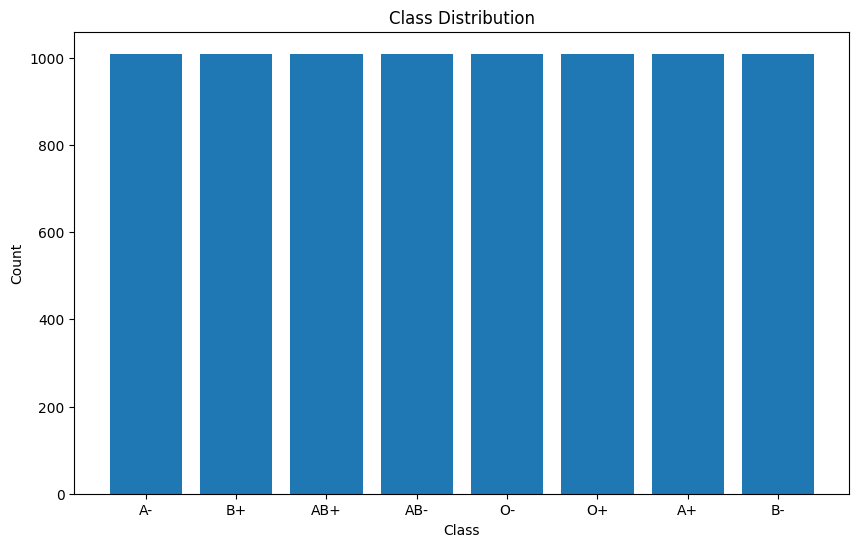

In [ ]:
#step - 1 : Balance the dataset
balanced_datasets=[]
for class_id , count in class_counts.items():
  balanced_datasets.append(oversample_class(class_id,count,max_count))

#step - 2 : Combine balanced datasets
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

#step-3 : check balanced class distribution
balanced_class_counts =Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names,balanced_class_counts)

# step-4: batch the balanced dataset
balanced_dataset= balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
#checking the dataset format
for sample in balanced_dataset.take(10):
  print(sample[0].shape)


(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [ ]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size= sum(1 for _ in balanced_dataset_unbatched)
print(f"Total number of samples in the balanced dataset: {dataset_size}")

Total number of samples in the balanced dataset: 8064


In [ ]:
#unbatch the dataset to work at the sample level
balance_dataset_unbatched= balanced_dataset.unbatch()

#compute sizes based on dataset size and desired splits
train_size= int(0.7*dataset_size)
val_size= int(0.15*dataset_size)

#split the dataset into training, validation and test
train_dataset= balanced_dataset_unbatched.take(train_size)
val_test_dataset= balance_dataset_unbatched.skip(train_size)
val_dataset= val_test_dataset.take(val_size)
test_dataset= val_test_dataset.skip(val_size)

#Rebatch the datasets after splitting
train_dataset=train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset=val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset=test_dataset.batch(BATCH_SIZE, drop_remainder=True)

#check the number of batches in each dataset
train_batch_count= sum(1 for _ in train_dataset)
val_batch_count= sum(1 for _ in val_dataset)
test_batch_count= sum(1 for _ in test_dataset)

print(f"Number of batches in the training dataset: {train_batch_count}")
print(f"Number of batches in the validation dataset: {val_batch_count}")
print(f"Number of batches in the test dataset: {test_batch_count}")


Number of batches in the training dataset: 176
Number of batches in the validation dataset: 37
Number of batches in the test dataset: 37


In [ ]:
def create_high_accuracy_model():
  model=tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32,(3,3),activation="relu", padding='same',input_shape=(64,64,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(64,(3,3),activation="relu", padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Conv2D(128,(3,3),activation="relu", padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

       tf.keras.layers.Conv2D(256,(3,3),activation="relu", padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Conv2D(512,(3,3),activation="relu", padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1024,activation="relu"),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Dense(len(class_names), activation='softmax')
  ])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

# Create the model
high_acc_model = create_high_accuracy_model()

# Print the model summary
high_acc_model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,674,952 (14.02 MB)

 Trainable params: 3,674,952 (14.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#define reduceLRonPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6

)

# define EarlyStopping callback to stop training when validation loss doesn't improve
early_stop= EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


In [ ]:
# train the model
history_high_acc= high_acc_model.fit(
	train_dataset,
	validation_data= val_dataset,
	epochs=20,
	callbacks=[reduce_lr,early_stop]
)

Epoch 1/20
    176/Unknown 95s 515ms/step - accuracy: 0.1226 - loss: 52.6698

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 108s 588ms/step - accuracy: 0.1226 - loss: 52.4465 - val_accuracy: 0.1242 - val_loss: 2.0209 - learning_rate: 0.0010
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 587ms/step - accuracy: 0.1953 - loss: 2.0152 - val_accuracy: 0.1743 - val_loss: 1.8774 - learning_rate: 0.0010
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 141s 804ms/step - accuracy: 0.3985 - loss: 1.5641 - val_accuracy: 0.3923 - val_loss: 1.6085 - learning_rate: 0.0010
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 581ms/step - accuracy: 0.5689 - loss: 1.1913 - val_accuracy: 0.3865 - val_loss: 1.6084 - learning_rate: 0.0010
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 808ms/step - accuracy: 0.6044 - loss: 1.0538 - val_accuracy: 0.5757 - val_loss: 1.3337 - learning_rate: 0.0010
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 584ms/step - accuracy: 0.6645 - loss: 0.9504 - val_accuracy: 0.4227 - val_loss: 1.5649 - learning_rate: 0.0010
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 141s 579ms/step - accuracy: 0.6696

In [ ]:
high_acc_eval= high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.8553 - loss: 0.6253
High Accuracy Model - Loss: 0.6038557887077332, Accuracy: 0.8330591917037964


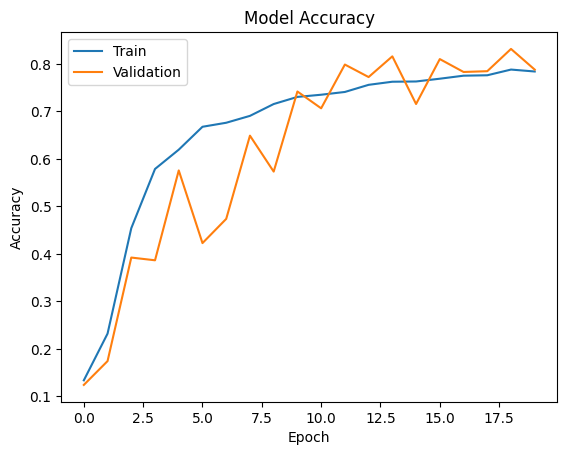

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy values
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','Validation'], loc='upper left')
  plt.show()

plot_accuracy(history_high_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

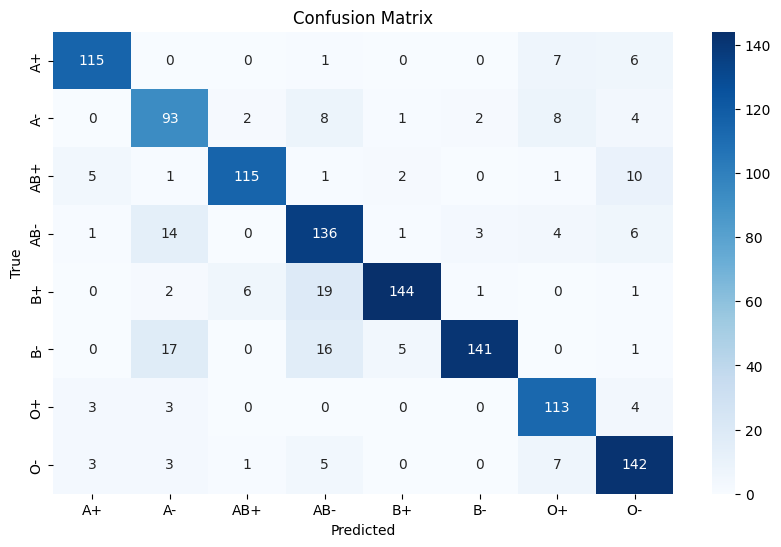

In [ ]:
#Get predictions on the test dataset
y_true=[]
y_pred=[]

#iterate over the test dataset and collect the true and predicted labels
for images,labels in test_dataset:
  predictions= high_acc_model.predict(images)
  predicted_labels= np.argmax(predictions, axis=1) #conver one-hot encoded predictions to class labels
  y_true.extend(labels.numpy()) #convert tensor to numpy array and append
  y_pred.extend(predicted_labels) #Append the predicted labels

  #conver to numpy arrays
y_true= np.array(y_true)
y_pred = np.array(y_pred)

#classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

#Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

#plot confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

